In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats
import statsmodels.api as sm

failure_stresses = pd.DataFrame(
    [
        [2.247, 2.640, 2.842, 2.908, 3.099, 3.126, 3.245, 3.328, 3.355, 3.383, 3.572, 3.581, 3.681],
        [1.901, 2.132, 2.203, 2.228, 2.257, 2.35, 2.361, 2.396, 2.397, 2.445, 2.454, 2.454, 2.474],
        [1.312, 1.314, 1.479, 1.552, 1.700, 1.803, 1.861, 1.865, 1.944, 1.958, 1.966, 1.997, 2.006],
        [1.339, 1.434, 1.549, 1.574, 1.589, 1.613, 1.746, 1.753, 1.764, 1.807, 1.812, 1.840, 1.852],
    ],    
    index=pd.Series([1, 10, 20, 50], name='Length (mm)'))

In [2]:
with open('p2_data.tex', 'w') as f:
    f.write(failure_stresses.reset_index().to_latex(index=False))
failure_stresses

,0,1,2,3,4,5,6,7,8,9,10,11,12
Length (mm),,,,,,,,,,,,,
1,2.247,2.640,2.842,2.908,3.099,3.126,3.245,3.328,3.355,3.383,3.572,3.581,3.681
10,1.901,2.132,2.203,2.228,2.257,2.350,2.361,2.396,2.397,2.445,2.454,2.454,2.474
20,1.312,1.314,1.479,1.552,1.700,1.803,1.861,1.865,1.944,1.958,1.966,1.997,2.006
50,1.339,1.434,1.549,1.574,1.589,1.613,1.746,1.753,1.764,1.807,1.812,1.840,1.852


In [281]:
from scipy import optimize

def fit_exponential_model(y):
    lambda_hat = 1/np.mean(y)
    return lambda_hat, np.square(lambda_hat)/len(y)

def fit_quasi_likelihood_model(y):
    lambda_hat, lambda_hat_variance = fit_exponential_model(y)    
    alpha_hat = np.square(lambda_hat)*np.sum(np.square(y - 1/lambda_hat))/(len(y) - 1)    
    return lambda_hat, lambda_hat_variance*alpha_hat, alpha_hat

def fit_sandwich_model(y):
    lambda_hat, _ = fit_exponential_model(y)
    return lambda_hat, np.power(lambda_hat, 4)*np.mean(np.square(y - 1/lambda_hat))/len(y)

def fit_weibull_model(y):
    def score(params):
        eta = params[0]
        alpha = params[1]
        n = len(y)
        fixed = n*np.array([
            1/eta - np.log(alpha),
            -eta/alpha,
        ])
        summed = np.sum(np.array([
            np.log(y)-(np.log(y) - np.log(alpha))*np.power(y/alpha, eta),
            (eta/alpha)*np.power(y/alpha, eta)
        ]).transpose((1,0)), axis=0)
        
        return fixed + summed    
    params = optimize.root(score, np.array([10,3]))['x']
    return params
fit_weibull_model(failure_stresses.loc[1])

array([10.33405746,  3.31898401])

In [280]:
3.31898401*special.gamma(1 + 1/10.33405746)

3.161869915297437

In [270]:
1/3.15842894

0.3166131070214928

In [267]:
stats.weibull_min.fit(failure_stresses.loc[1], floc=0)

(10.33408746584655, 0, 3.318985239408275)

In [268]:
1/3.318985239408275

0.3012969109131335

## Exponential Model

In [223]:
def exponential_model_as_dict(fit, y):
    lambda_hat, lambda_hat_variance = fit(y)
    return {
        '$\\hat{\\lambda}$': lambda_hat,
        'Standard error': np.sqrt(lambda_hat_variance),
    }

failure_stresses_exponential_estimates = failure_stresses.apply(
    lambda y: exponential_model_as_dict(fit_exponential_model, y), axis=1, result_type='expand')

with open('p2_exponential_estimates.tex', 'w') as f:
    f.write(failure_stresses_exponential_estimates.reset_index().to_latex(
        index=False, escape=False))
    
failure_stresses_exponential_estimates

,$\hat{\lambda}$,Standard error
Length (mm),,
1,0.317019,0.087925
10,0.432584,0.119977
20,0.571253,0.158437
50,0.599852,0.166369


## Quasi-likelihood Model

In [224]:
from collections import OrderedDict

def quasi_likelihood_model_as_dict(fit, y):
    lambda_hat, lambda_hat_variance, alpha_hat = fit(y)
    return OrderedDict([
        ('$\\hat{\\lambda}$', lambda_hat),
        ('$\\hat{\\alpha}$', alpha_hat),
        ('Standard error', np.sqrt(lambda_hat_variance)),
    ])

failure_stresses_quasi_likelihood_estimates = failure_stresses.apply(
    lambda y: quasi_likelihood_model_as_dict(fit_quasi_likelihood_model, y), axis=1, result_type='expand')
failure_stresses_quasi_likelihood_estimates = failure_stresses_quasi_likelihood_estimates[
    failure_stresses_quasi_likelihood_estimates.columns[[1,0,2]]]

with open('p2_quasi_likelihood_estimates.tex', 'w') as f:
    f.write(failure_stresses_quasi_likelihood_estimates.reset_index().to_latex(
        index=False, escape=False))

failure_stresses_quasi_likelihood_estimates

,$\hat{\lambda}$,$\hat{\alpha}$,Standard error
Length (mm),,,
1,0.317019,0.016873,0.011421
10,0.432584,0.005078,0.008550
20,0.571253,0.021199,0.023068
50,0.599852,0.009633,0.016329


## Sandwich Estimation

In [225]:
failure_stresses_sandwich_estimates = failure_stresses.apply(
    lambda y: exponential_model_as_dict(fit_sandwich_model, y), axis=1, result_type='expand')

with open('p2_sandwich_estimates.tex', 'w') as f:
    f.write(failure_stresses_sandwich_estimates.reset_index().to_latex(
        index=False, escape=False))

failure_stresses_sandwich_estimates

,$\hat{\lambda}$,Standard error
Length (mm),,
1,0.317019,0.010973
10,0.432584,0.008215
20,0.571253,0.022163
50,0.599852,0.015688


In [210]:
def plot_estimate_quantiles(axes, plot_fn, estimates):
    for i, (length, estimate) in enumerate(estimates.iterrows()):
        ax = axes[i//2][i % 2]
        plot_fn(ax, length, estimate)       
        ax.set_title('Length = {}mm'.format(length))
        ax.grid(True)
        ax.set_aspect('equal', adjustable='datalim')    
        min_datalim = np.min([ax.get_xlim(), ax.get_ylim()])
        max_datalim = np.max([ax.get_xlim(), ax.get_ylim()])
        ax.plot([min_datalim, max_datalim], [min_datalim, max_datalim], '--k')        

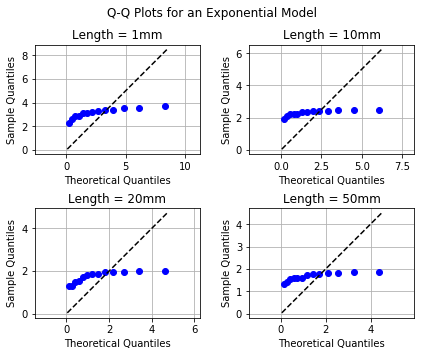

In [211]:
fig, axes = plt.subplots(figsize=(6,5), ncols=2, nrows=2)

def plot_exponential_model_quantiles(ax, length, estimate):
    lambda_hat = estimate[0]
    sm.qqplot(failure_stresses.loc[length], dist=stats.expon, loc=0, scale=1/lambda_hat, ax=ax)
    
plot_estimate_quantiles(axes, plot_exponential_model_quantiles, failure_stresses_exponential_estimates)

fig.suptitle('Q-Q Plots for an Exponential Model')
fig.tight_layout()
fig.subplots_adjust(top=0.875)
fig.savefig('p2_qq_exponential.pdf', bbox_inches='tight')

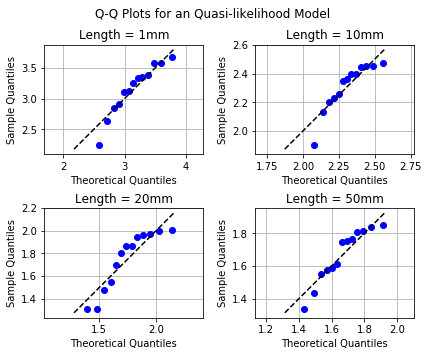

In [209]:
fig, axes = plt.subplots(figsize=(6,5), ncols=2, nrows=2)

def plot_quasi_likelihood_quantiles(ax, length, estimate):
    lambda_hat = estimate[0]
    alpha_hat = estimate[1]
    sm.qqplot(failure_stresses.loc[length], dist=stats.gamma,
              distargs=(1/alpha_hat,),
              loc=0, scale=alpha_hat/lambda_hat, ax=ax)

plot_estimate_quantiles(axes, plot_quasi_likelihood_quantiles,
                        failure_stresses_quasi_likelihood_estimates)

fig.suptitle('Q-Q Plots for an Quasi-likelihood Model')
fig.tight_layout()
fig.subplots_adjust(top=0.875)
fig.savefig('p2_qq_quasi_likelihood.pdf', bbox_inches='tight')

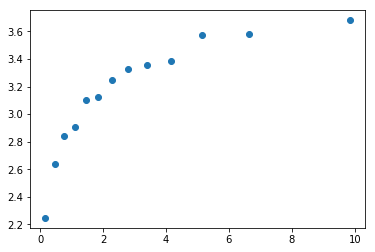

In [145]:
x = failure_stresses.loc[1]
#x = stats.expon.rvs(scale=1/0.317019, size=1000)
#x = stats.gamma.rvs(1/0.8933964103452493, scale=1/0.317019, size=1000)
theoretical_quantiles = stats.gamma.ppf(np.linspace(start=0.5, stop=len(x) - 0.5, num=len(x))/len(x),
                                        1/0.8933964103452493, scale=0.8933964103452493/0.317019)
plt.plot(theoretical_quantiles, np.sort(x), 'o');
#plt.set_aspect('equal', adjustable='datalim')
#plt.plot([0, 20], [0, 20], 'k--');

In [259]:
stats.weibull_min.fit(failure_stresses.loc[1], floc=0)

(10.33408746584655, 0, 3.318985239408275)

In [237]:
from scipy import special

3.318985239408275*special.gamma(1 + 1/10.33408746584655)

3.161871467095595

In [235]:
1/0.432584

2.311689752741664

In [177]:
1/0.01687323504043126

59.26545784515079

In [148]:
1/0.8933964103452493

1.1193239511826045

In [167]:
#tmp = np.concatenate(
#    (failure_stresses.loc[1],
#     failure_stresses.loc[1])) - 1/0.317019
tmp = failure_stresses.loc[1] - 1/0.317019

np.square(0.317019)*np.sum(np.square(tmp))/(len(tmp) - 1)

0.016873230193941668

In [124]:
np.mean(stats.gamma.rvs(1/0.8933964103452493, scale=1/0.317019, size=1000))

3.502560254404734

In [121]:
theoretical_quantiles

array([ 0.12371723,  0.38673493,  0.67369495,  0.98939672,  1.3402452 ,
        1.73505795,  2.18645312,  2.71340603,  3.34639867,  4.13914115,
        5.20050415,  6.81184487, 10.27729107])

22.228730375471372

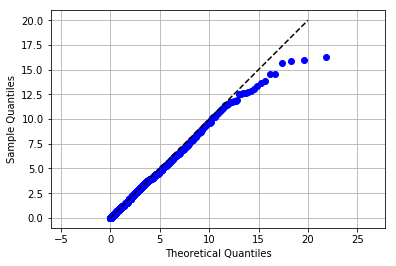

In [60]:
fig = plt.figure()
ax = fig.gca()
sm.qqplot(x, dist=stats.expon, loc=0, scale=1/0.317019, ax=ax);
ax.grid(True)
ax.grid(True)
ax.set_aspect('equal', adjustable='datalim')
ax.plot([0, 20], [0, 20], 'k--');
np.max([ax.get_xlim(), ax.get_ylim()])

In [16]:
stats.expon.fit(x)

(0.0003401704439788388, 3.2886255453876836)

In [87]:
np.mean(stats.expon.rvs(scale=1/0.317019, size=100000))

3.1479472556089343

In [74]:
np.mean(failure_stresses.loc[1])

3.1543846153846156

In [150]:
1/59.0011211110673

0.016948830482687596